In [ ]:
# importing the libraries
import pandas as pd
import numpy as np
import os
import time
import copy

# for reading and displaying images
import skimage.io as io
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets,models, transforms
from torchvision import utils
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
import torch.nn.functional as F
from torch.optim import Adam, SGD

# Connection with drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# The root directory of the data
if os.getcwd() == '/content':
  os.chdir('gdrive')
if os.getcwd() == '/content/gdrive':
  os.chdir('MyDrive')

In [ ]:
os.getcwd()

'/content/gdrive/My Drive'

In [ ]:
## Load the data
#data_dir = 'Fish_Dataset_wGT/'
data_dir = 'Fish_Dataset/'
data_transforms = transforms.Compose([transforms.ToTensor()])
image_datasets = datasets.ImageFolder(os.path.join(data_dir),
                                          data_transforms)

In [ ]:
image_datasets

Dataset ImageFolder
    Number of datapoints: 5006
    Root location: Fish_Dataset/
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [ ]:
n = len(image_datasets)
n_train = int(n*0.75)
n_test = n - n_train
print("N: {} = n_train: {} + n_test: {}".format(n,n_train,n_test))

N: 5006 = n_train: 3754 + n_test: 1252


In [ ]:
subset_train, subset_test = torch.utils.data.random_split(image_datasets, [n_train,n_test], generator=torch.Generator().manual_seed(42))

In [ ]:
subset_datasets = {'train': subset_train, 'test': subset_test}

# Dataset sizes
dataset_sizes = {x: len(subset_datasets[x]) for x in ['train', 'test']}
print("Datasizes: {}".format(dataset_sizes))

# Names of the classes
class_names = subset_datasets['train'].dataset.classes
print("Number of classes: {}".format(len(class_names)))
print("Classes: {}".format(class_names))

# In case GPU is needed
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print("Cuda available")

Datasizes: {'train': 3754, 'test': 1252}
Number of classes: 5
Classes: ['Black Sea Sprat', 'Red Mullet', 'Red Sea Bream', 'Shrimp', 'Trout']


In [ ]:
## Visualizing images

# dataloader
dataloaders = {x: torch.utils.data.DataLoader(subset_datasets[x].dataset, batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}

# Function to display and image from a tensor
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

# Display 4 images with their respective classnames as title
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
## Create the train function with 10 epochs by default
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    losses_train, losses_test = [], []
    accs_train, accs_test = [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            i = 0
            for inputs, labels in dataloaders[phase]:
                i += 1
                if i%300==0:
                      print("Contador :{} ; Phase : {}".format(i,phase))
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            print("Contador: {} ; Contador dividido 4 : {}".format(i,i/4))
            print("Dataset Size of {} : {}".format(phase,dataset_sizes[phase]))
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'train':
              losses_train.append(epoch_loss)
              accs_train.append(epoch_acc)
            if phase == 'train':
              losses_test.append(epoch_loss)
              accs_test.append(epoch_acc)


            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    losses = [losses_train, losses_test]
    accs = [accs_train, accs_test]

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, losses, accs

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
# Just a function that helped me calculate the size of the layers
def outputSize(in_size, kernel_size, stride, padding):
  output = int((in_size - kernel_size + 2*(padding)) / stride) + 1
  return(output)

In [ ]:
## Creating the Network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # This network will have 1 convolutional network, one maxpool operation
        # and 2 linear layers to complement. 
        # 590 x 445
        # Images has 3 channels of input and there are 5 classes (output size)
        self.conv1 = torch.nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = torch.nn.Linear(18 * 295 * 222, 64)
        self.fc2 = torch.nn.Linear(64, 5)

    def forward(self, x):
        # Relu activation function
        x = F.relu(self.conv1(x))
        
        # Applying Maxpooling
        x = self.pool(x)
        
        # Reshape data to 18 * 295 * 222 =  281250
        x = x.view(-1, 18 * 295 * 222)
        
        # Activation of the first fully connected layer also with Relu
        x = F.relu(self.fc1(x))
        
        #Computes the second fully connected layer 
        x = self.fc2(x)
        return(x)

In [ ]:
outputSize(18,2,2,0)

9

In [ ]:
# instantiate CNN model
model_ft = CNN()
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# to change the learning rate by runtime
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# Finally train the model
model_ft, losses, accs = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
Contador :300 ; Phase : train
Contador :600 ; Phase : train
Contador :900 ; Phase : train
Contador :1200 ; Phase : train
Contador: 1252 ; Contador dividido 4 : 313.0
Dataset Size of train : 3754
train Loss: 0.8668 Acc: 1.0024
Contador :300 ; Phase : test
Contador :600 ; Phase : test
Contador :900 ; Phase : test
Contador :1200 ; Phase : test
Contador: 1252 ; Contador dividido 4 : 313.0
Dataset Size of test : 1252
test Loss: 1.0294 Acc: 3.6350
Epoch 1/4
----------
Contador :300 ; Phase : train
Contador :600 ; Phase : train
Contador :900 ; Phase : train
Contador :1200 ; Phase : train
Contador: 1252 ; Contador dividido 4 : 313.0
Dataset Size of train : 3754
train Loss: 0.3311 Acc: 1.2200
Contador :300 ; Phase : test
Contador :600 ; Phase : test
Contador :900 ; Phase : test
Contador :1200 ; Phase : test
Contador: 1252 ; Contador dividido 4 : 313.0
Dataset Size of test : 1252
test Loss: 0.4470 Acc: 3.8474
Epoch 2/4
----------
Contador :300 ; Phase : train
Contador :600 ;

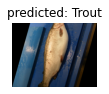

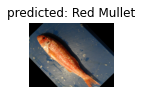

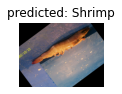

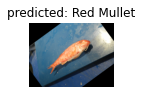

In [ ]:
visualize_model(model_ft)

In [ ]:
# And finally we evaluate 
nb_classes = 5
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[9.9700e+02, 0.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00],
        [0.0000e+00, 1.0000e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+03, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 9.9900e+02, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 1.0040e+03]])
